# Importing and Transforming Survey data
This notebook demonstrates how to import, transform, and explore the survey data, which can be used to replicate any statistical analyses in the paper. First, we begin by importing some utility functions defined in `src/utils.py`.

In [1]:
%matplotlib inline
from src.utils import *

**If you'd like to work with the processed data, jump to the next section.** Else continue.
## Importing Raw Survey Data
We begin by importing the data dictionary for the variables in the survey.

In [2]:
dd = import_datadict()

This dictionary contains two dictionaries:
1. `dd['desc']`: corresponds to the description of survey questions asked
2. `dd['dict']`: contains the mapping of values of the question and its recode

Let's explore the fieldname `DGEN`.

In [3]:
dd['desc']['DGEN'], dd['dict']['DGEN']

('What is your gender?',
 {'Male': 1, 'Female': 2, 'Other': 3, 'Prefer not to answer': 4})

Next, we import the actual survey data into a [Pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html), whose rows correspond to samples and columns to fieldnames.

In [4]:
df = import_data()
print(df.shape)
print(list(df))

(8002, 194)
['record', 'uuid', 'date', 'status', 'country', 'DGEOUS', 'USregion', 'DGEOUSb', 'DGEOUK', 'DAGE', 'agerecode', 'DGEN', 'DEDUUS', 'DEDUUSr7oe', 'DEDUUK', 'DEDUUKr8oe', 'DEMP', 'DREL', 'DRELr3oe', 'DRELr8oe', 'DPOLUS', 'DPOLUSIND', 'DPOLUK', 'DPOLUKr5oe', 'DETHUK', 'DETHUKr12oe', 'DETHUS', 'DETHUSr7oe', 'DLANUK', 'DLANUKr6oe', 'DLANUS', 'DLANUSr5oe', 'DINCUK', 'DINCUS', 'QINFr1', 'QINFr2', 'QINFr3', 'QINFr4', 'QINFr5', 'QINFr6', 'QSHD', 'QKNLr1', 'QKNLr2', 'QKNLr3', 'QKNLr4', 'QKNLr5', 'QKNLr6', 'QKNLr7', 'QCOVVCIr1', 'QCOVVCIr2', 'QCOVVCIr3', 'QCOVVCIr4', 'QCOVVCIr5', 'QCOVVCIr6', 'QVCIr1', 'QVCIr2', 'QVCIr3', 'QVCIr4', 'QSRCUKr1', 'QSRCUKr2', 'QSRCUKr3', 'QSRCUKr4', 'QSRCUKr5', 'QSRCUKr6', 'QSRCUKr7', 'QSRCUKr8', 'QSRCUKr9', 'QSRCUKr10', 'QSRCUKr11', 'QSRCUKr12', 'QSRCUKr13', 'QSRCUKr14', 'QSRCUKr15', 'QSRCUKr16', 'QSRCUKr15oe', 'QSRCUSr1', 'QSRCUSr2', 'QSRCUSr3', 'QSRCUSr4', 'QSRCUSr5', 'QSRCUSr6', 'QSRCUSr7', 'QSRCUSr8', 'QSRCUSr9', 'QSRCUSr10', 'QSRCUSr11', 'QSRCUSr12',

It appears that there are 8002 samples, and 194 fields. Note that field names match the corresponding question in the questionnaire (see `doc/`). But these are not easy to comprehend. Next, we transform the data which largely involves recoding the variables and relabeling them aptly. We will also save these files so that one may directly work with them, instead of the raw survey data.

In [5]:
df_uk, dd_uk = transform_data(df, dd, 'UK', save='dat/orb_uk')
df_us, dd_us = transform_data(df, dd, 'USA', save='dat/orb_us')

## Importing and Exploring Transformed Survey Data
Once saved, we now use a helper function to import the transformed data.

In [6]:
df_uk, dd_uk = import_transformed_data('dat/orb_uk')
df_us, dd_us = import_transformed_data('dat/orb_us')

Let's print out the field names in the UK DataFrame, which should now be quite comprehensible. 

In [7]:
print(list(df_uk))

['Trust:Television', 'Trust:Radio', 'Trust:Newspapers', 'Trust:Govt. Briefings', 'Trust:National Health Authorities', 'Trust:International Health Authorities', 'Trust:Healthcare Workers', 'Trust:Scientists', 'Trust:Govt. Websites', 'Trust:Social Media', 'Trust:Celebrities', 'Trust:Search Engines', 'Trust:Family and friends', 'Trust:Work Guidelines', 'Trust:Other', 'Trust:None of these', 'Reason:Unsure if safe', 'Reason:Unsure if effective', 'Reason:Not at risk', 'Reason:Wait until others', "Reason:Won't be ill", 'Reason:Other effective treatments', 'Reason:Already acquired immunity', 'Reason:Approval may be rushed', 'Reason:Other', 'Reason:Do not know', 'Image 1:Vaccine Intent', 'Image 1:Agreement', 'Image 1:Trust', 'Image 1:Fact-check', 'Image 1:Share', 'Image 2:Vaccine Intent', 'Image 2:Agreement', 'Image 2:Trust', 'Image 2:Fact-check', 'Image 2:Share', 'Image 3:Vaccine Intent', 'Image 3:Agreement', 'Image 3:Trust', 'Image 3:Fact-check', 'Image 3:Share', 'Image 4:Vaccine Intent', 'Im

We can now explore what this data contains. Using a helper function, we can obtain the counts and percentages of respondents across different socio-demographic categories, broken down by some other variable of interest. Say, we wish to know how the respondents are distributed across the Treatment and Control groups.

In [8]:
get_socdem_counts(df_uk, dd_uk, 'Treatment')

Control (N)  Control (%)  \
Age                18-24                                 140         14.0   
                   25-34                                 227         22.7   
                   35-44                                 190         19.0   
                   45-54                                 162         16.2   
                   55-64                                 127         12.7   
                   65+                                   154         15.4   
Gender             Male                                  421         42.1   
                   Female                                573         57.3   
                   Other                                   6          0.6   
Education          Level-0                                40          4.0   
                   Level-1                               276         27.6   
                   Level-2                               190         19.0   
                   Level-3                               258         25.8   
                   Level-4                               163         16.3   
                   Other                                  73          7.3   
Employment         Employed                              619         61.9   
                   Unemployed                             56          5.6   
                   Student                                64          6.4   
                   Retired                               151         15.1   
                   Other                                 110         11.0   
Religion           Christian                             442         44.2   
                   Jewish                                 10          1.0   
                   Muslim                                 34          3.4   
                   Atheist                               342         34.2   
                   Other                                 172         17.2   
Political          Conservative                          307         30.7   
                   Labour                                350         35.0   
                   Liberal-Democrat                       87          8.7   
                   SNP                                    44          4.4   
                   Other                                 212         21.2   
Ethnicity          White                                 872         87.2   
                   Black                                  27          2.7   
                   Asian                                  82          8.2   
                   Other                                  19          1.9   
Income             Level-0                               154         15.4   
                   Level-1                               197         19.7   
                   Level-2                               167         16.7   
                   Level-3                               230         23.0   
                   Level-4                               184         18.4   
                   Other                                  68          6.8   
Social media usage None                                  136         13.6   
                   Less than 10 minutes per day          122         12.2   
                   10–30 minutes per day                 215         21.5   
                   31–60 minutes per day                 160         16.0   
                   1–2 hours per day                     154         15.4   
                   2–3 hours per day                      94          9.4   
                   More than 3 hours per day             119         11.9   

                                                 Treatment (N)  Treatment (%)  
Age                18-24                                   364           12.1  
                   25-34                                   575           19.2  
                   35-44                                   586           19.5  
                   45-54        

The above forms **Table 1** of the paper. We can also see how the respondents are distributed, when broken down by their inclination to get vaccinated for COVID-19.

In [9]:
get_socdem_counts(df_uk, dd_uk, 'Vaccine Intent for self (Pre)')

Yes, definitely (N)  \
Age                18-24                                         227   
                   25-34                                         392   
                   35-44                                         389   
                   45-54                                         353   
                   55-64                                         329   
                   65+                                           477   
Gender             Male                                         1051   
                   Female                                       1109   
                   Other                                           7   
Education          Level-0                                        92   
                   Level-1                                       574   
                   Level-2                                       352   
                   Level-3                                       597   
                   Level-4                                       389   
                   Other                                         163   
Employment         Employed                                     1332   
                   Unemployed                                     97   
                   Student                                        91   
                   Retired                                       461   
                   Other                                         186   
Religion           Christian                                     996   
                   Jewish                                         31   
                   Muslim                                         63   
                   Atheist                                       749   
                   Other                                         328   
Political          Conservative                                  788   
                   Labour                                        778   
                   Liberal-Democrat                              178   
                   SNP                                            93   
                   Other                                         330   
Ethnicity          White                                        1961   
                   Black                                          53   
                   Asian                                         133   
                   Other                                          20   
Income             Level-0                                       279   
                   Level-1                                       405   
                   Level-2                                       415   
                   Level-3                                       555   
                   Level-4                                       413   
                   Other                                         100   
Social media usage None                                          313   
                   Less than 10 minutes per day                  310   
                   10–30 minutes per day                         462   
                   31–60 minutes per day                         327   
                   1–2 hours per day                             331   
                   2–3 hours per day                             190   
                   More than 3 hours per day                     234   

                                                 Yes, definitely (%)  \
Age                18-24                                        10.5   
                   25-34                                        18.1   
                   35-44                                        18.0   
                   45-54                                        16.3   
                   55-64                                        15.2   
                   65+                                          22.0   
Gender             Male                                         48.5   
                

Tables are useful for fine details, but some visualisation can help! We use some helper functions to see the distribution of people across difference vaccine acceptance categories in the UK.

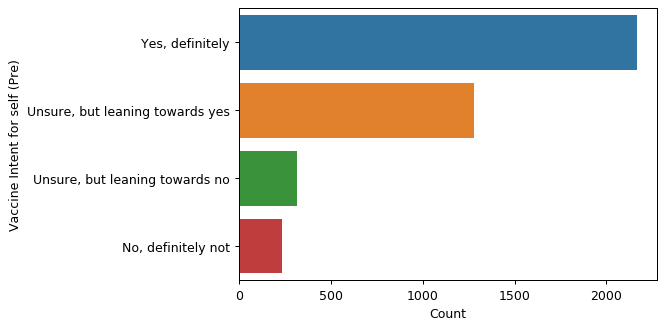

Yes, definitely                    0.54175
Unsure, but leaning towards yes    0.31925
Unsure, but leaning towards no     0.07950
No, definitely not                 0.05950
Name: Vaccine Intent for self (Pre), dtype: float64

In [10]:
count_attribute(df_uk, 'Vaccine Intent for self (Pre)', dd=dd_uk, norm=True, plot=True)

It may be more interesting to see how people change their vaccine opinions upon being shown misinformation about COVID-19 vaccines (Treatment=1).

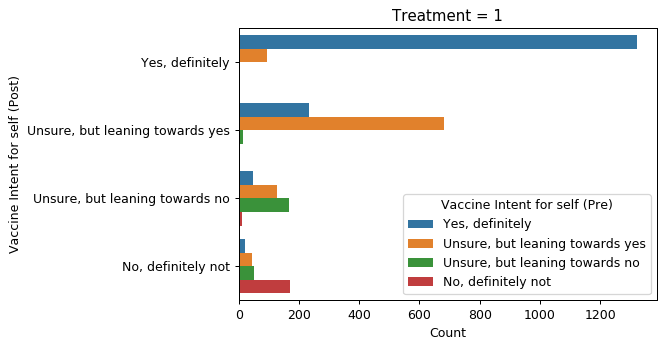

,"Yes, definitely","Unsure, but leaning towards yes","Unsure, but leaning towards no","No, definitely not"
"Yes, definitely",0.814154,0.100105,0.012821,0.026042
"Unsure, but leaning towards yes",0.142769,0.719705,0.064103,0.026042
"Unsure, but leaning towards no",0.030154,0.133825,0.709402,0.062500
"No, definitely not",0.012923,0.046365,0.213675,0.885417


In [11]:
count_attribute(df_uk, 'Vaccine Intent for self (Post)', 'Vaccine Intent for self (Pre)', dd=dd_uk, where=('Treatment', 1), norm=True, plot=True)

Or how people change their vaccine opinions upon being shown factual information about COVID-19 vaccines (Treatment=0).

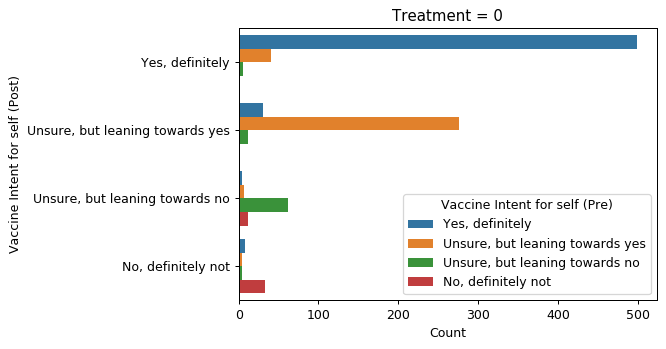

,"Yes, definitely","Unsure, but leaning towards yes","Unsure, but leaning towards no","No, definitely not"
"Yes, definitely",0.920664,0.125000,0.071429,0.000000
"Unsure, but leaning towards yes",0.057196,0.841463,0.142857,0.021739
"Unsure, but leaning towards no",0.007380,0.021341,0.738095,0.260870
"No, definitely not",0.014760,0.012195,0.047619,0.717391


In [12]:
count_attribute(df_uk, 'Vaccine Intent for self (Post)', 'Vaccine Intent for self (Pre)', dd=dd_uk, where=('Treatment', 0), norm=True, plot=True)